###### The latest version of this Jupyter notebook is available at [http://github.com/jckantor/CBE30338](http://github.com/jckantor/CBE30338)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

Jeffrey C. Kantor (Kantor.1@nd.edu)

# Balancing a Ball on a Beam with Proportional-Derivative Control

This notebook illustrates the principles of proportional-derivative feedback through an interactive simulation of a ball on beam apparatus. The task is to choose the control parameters to balance the ball at desired locations on the beam with acceptable dynamics and without dropping the ball off the ends. The simulation in intended for use in a lecture demonstration and for out-of-class reinforcement of key concepts in feedback control. Suggested exercises are included.

The notebook is organized as a single Jupyter notebook requiring only standard python libraries.

## Table of Contents

* [Initialization](#Initialization). This section loads needed libraries and defines functions to display and update a diagram of the ball and beam apparatus, and to create plots of the ball position and beam angle. These cells need to be executed for subsequent simulations.
* [Ball on Beam Dynamics](#Simulation/Animation). This section presents a model for the dynamics of the ball on beam system, and demonstrates the behavior with an open-loop simulation of the device.
* [Proportional-Derivative Control](#Proportional-Derivative Control). This section introduces a proportional-derivative feedback control. Simulations can be run for different choices of setpoints and control parameters.
* [Exercises](#Exercises). A short set of exercises to reinforce control concepts, and introduce methods to analyze the performance of the ball on beam control system.

<a id='Initialization'></a>
## Initialization

The following cells contain utility functions to display and update a figure illustrating the ball and beam apparatus. These cells need to be executed in order to run the control simulations later in this notebook, but the details can be safely ignored by anyone primarily interested in the subsequent applications of feedback control.

In [1]:
%matplotlib notebook

from pylab import *
import time
from ipywidgets import interact, interactive

# limit on beam angle in radians
ulimit = 0.2

def draw_beam(fig,ax):
    # Draw the ball and beam diagram on a given figure and axis
    ax.axis('off')
    ax.axis('equal')
    ax.set(xlim = (-0.2,1.2), ylim = (-0.3,0.3))
    
    # draw ball, beam, and set point patch
    ax.plot(0.5,0.049,'r.',ms=50)
    ax.plot(array([0.0,cos(0.0)]), array([0.0,sin(0.0)]), lw=5)
    ax.add_patch(Polygon([[0.5, -0.01], [0.5-0.03, -0.05], [0.5+0.03, -0.05]]))

    # draw pivot patch
    ax.add_patch(Polygon([[0.0,0.0],[0.02,-0.25],[-0.02,-0.25]]))
    
    # beam hi and lo limit patches
    ulimit = 0.2
    xa = cos(ulimit)
    ya = sin(ulimit)
    ax.add_patch(Polygon([[xa-0.05, ya+0.01],[xa+0.05, ya+0.01], \
                          [xa+0.05, ya+0.02],[xa-0.05, ya+0.02]]))
    ax.add_patch(Polygon([[xa-0.05,-ya-0.01],[xa+0.05,-ya-0.01], \
                          [xa+0.05,-ya-0.02],[xa-0.05,-ya-0.02]]))
    fig.canvas.draw()

def update_beam(fig,ax,x,u,SP):
    # Update the ball and beam diagram with current state values.
    
    # Limit beam angle
    u = -ulimit if u < -ulimit else ulimit if u > ulimit else u
    
    # Determine ball position, and if it rolled off the beam
    x = -0.05 if x < 0 else 1.02 if x > 1.0 else x
    y = 0.049/cos(u) + x*sin(u) if x >= 0.0 and x <= 1.0 else -0.2

    # update ball, beam, and setpoint positions
    ax.lines[0].set(xdata=x, ydata=y)
    ax.lines[1].set(xdata=[0.0,cos(u)], ydata=[0.0,sin(u)])
    ax.patches[0].set_xy([[SP*cos(u), -0.01 + SP*sin(u)], \
              [SP*cos(u) - 0.03, -0.05 + SP*sin(u)], \
              [SP*cos(u) + 0.03, -0.05 + SP*sin(u)]])
    fig.canvas.draw()
    
def draw_plot(fig,ax,SP):
    
    # set up xplot to display ball position
    xplot = ax
    xplot.set(xlim=(0,tf),ylim=(0,1),xlabel='Time [dimensionless]',ylabel='Position')
    xplot.plot([],[],'b')
    xplot.plot([0,tf],[SP,SP],'b--')

    # set up second axist to display beam angle
    uplot = ax.twinx()
    uplot.set(xlim=(0,tf),ylim=(-ulimit,ulimit))
    uplot.set_ylabel('Beam Angle', color='r')
    for tl in uplot.get_yticklabels():
        tl.set_color('r')
    uplot.plot([],[],'r')
    uplot.plot([0,tf],[0,0],'r--')
    
    # return lines for updating
    return xplot,uplot

def update_plot(ax,t,y):
    tdata = append(ax.lines[0].get_xdata(),t)
    ydata = append(ax.lines[0].get_ydata(),y)
    ax.lines[0].set(xdata=tdata, ydata=ydata)
    

<a id='Ball on Beam Dynamics'></a>
## Ball on Beam Dynamics

We assume that a ball can roll freely and without friction on a tilted beam. The beam angle $u$ is measured in a counterclockwise direction from the horizontal, and is subject to the hard limits indicated by stops on the following diagram.  The position of the ball is given by $x$ on a beam of length $L$. The ball can fall of the either end of the beam. There is a triangular marker below the beam to indicate the location of a setpoint.

<IPython.core.display.Javascript object>


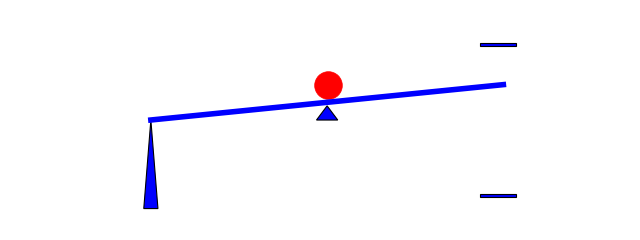

In [2]:
fig,ax = subplots(1,1,figsize=(8,3))
draw_beam(fig,ax)
update_beam(fig,ax,0.5,0.1,0.5)

The ball dynamics are modeled by a pair of differential equations

\begin{align*}
\frac{dx}{dt} & = v(t) \\
(\alpha+1)m\frac{dv}{dt} & = - m g \sin(u(t))
\end{align*}

where $x(t)$ denotes position of the ball on the beam, $v(t)$ is velocity, $u(t)$ is the angle of the beam relative to the horizontal, $m$ is the ball mass, and $g$ is acceleration due to gravity.

The motion of the ball is subject to both linear and rotational inertia. The linear inertia is the product of the ball's mass times acceleration. If the surface of the ball doesn't slip as it rolls on the beam, the rotational inertia can be expressed as a mutiple $\alpha$ of the ball's mass where $\alpha = \frac{2}{5}$ for a solid sphere, or $\alpha = \frac{2}{3}$ for a spherical shell. Wrapping these parameters into a single constant $K_b = \frac{g}{1+\alpha}$ results in a model

\begin{align*}
\frac{dx}{dt} & = v(t) \\
\frac{dv}{dt} & = - K_b \sin(u(t))
\end{align*}

where the variables all have common units.

An alternative is create a dimensionless model where a time scale $T$ is defined by

$$T  = \sqrt{\frac{(1+\alpha)L}{g}}$$

where $L$ is the length of the beam. Dimensionless variables are then given

\begin{align*}
\tilde{x} & = \frac{x}{L} \\
\tilde{t} & = \frac{t}{T} \\
\tilde{v} & = \frac{v T}{L}
\end{align*}

With these definitions in place, our simulation model becomes dimensionless where

\begin{align*}
\frac{d\tilde{x}}{d\tilde{t}} & = \tilde{v}(\tilde{t}) \\
\frac{d\tilde{v}}{d\tilde{t}} & = - \sin(u(\tilde{t}))
\end{align*}

Note the dimensionless model can be formed from the dimensional model with specific choices for $K_b$ and $L$.  In other words, there is no loss of generality if we proceed with the dimesional model under the assumption $K_b = 1$ and $L = 1$.

To demonstrate the dynamics, the following cell performs a simulation of how the ball on beam responds to a programmed change in beam angle. The simulation solves the differential equations with an Euler's approximation.  The simulation loop includes a `time.sleep(dt)` that inserts a pause in each step of the simulation. It's sometimes convenient to leave this out in order to see animation run as quickly as possible.

<IPython.core.display.Javascript object>


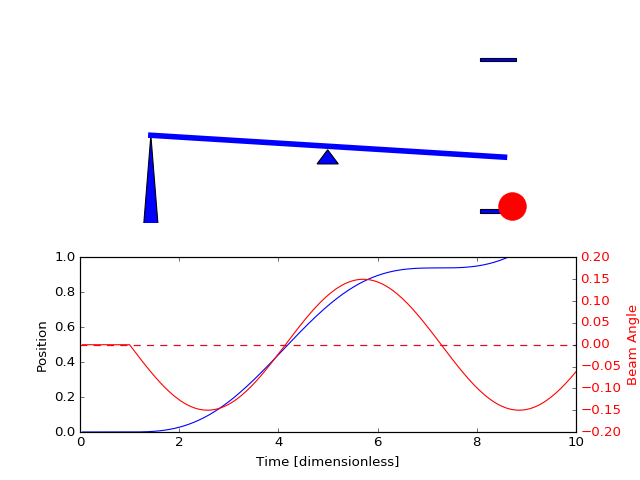

In [3]:
# simulation parameters
dt = 0.05
tf = 10.0

# initialize simulation 
t = 0.0      # initial time
x = 0.0      # initial ball position
v = 0.0      # initial ball velocity
u = 0.0      # initial beam angle
SP = 0.5     # initial set point

# set up figure window with two axes
fig,ax = subplots(2,1,figsize=(8,6))
beam_axes = ax[0]
plot_axes = ax[1]

# draw ball and beam apparatus
draw_beam(fig,beam_axes)
update_beam(fig,beam_axes,x,u,0.5)

# draw plotting axes
xplot,uplot = draw_plot(fig,plot_axes,SP)

# simulation/animation
for t in linspace(dt,10.0,10.0/dt):
    # beam angle
    u = 0.0 if t <= 1.0 else -0.15*sin(t-1.0)
    
    # update velocity and position
    v += -sin(u)*dt
    x += v*dt
    
    # update plots
    update_beam(fig,beam_axes,x,u,SP)
    update_plot(xplot,t,x)
    update_plot(uplot,t,u)
    
    # pause for time step
    # time.sleep(dt)

<a id="Proportional-Derivative Control"></a>
## Proportional-Derivative Control

The beam angle is primary control input. We choose to adjust the control using proportinal-derivative (PD) feedback in the form

$$u(t) = K_p (x(t) - x_{SP}) + K_d v(t)$$

where $K_p$ and $K_d$ are parameters determining the proportional and derivative control response.

<IPython.core.display.Javascript object>


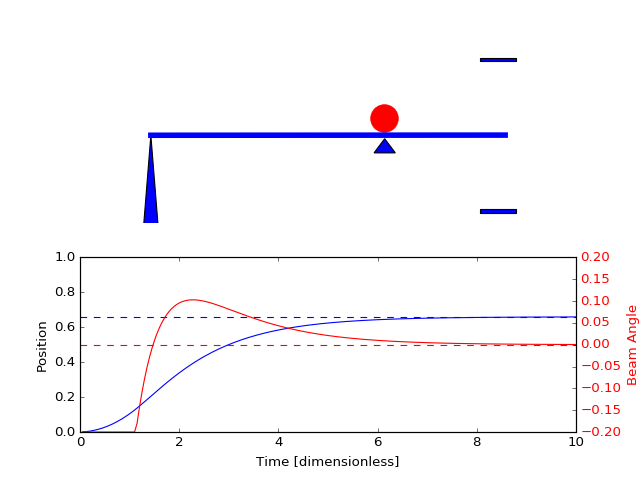

In [4]:
def ballbeam(SP, Kp, Kd):
    # initialize
    t = 0.0       # time
    x = 0.0       # ball position
    v = 0.0       # ball velocity
    u = 0.0       # beam angle
    
    # initialize graphics
    fig,ax = subplots(2,1,figsize=(8,6))
    draw_beam(fig,ax[0])  
    xplot,uplot = draw_plot(fig,ax[1],SP)

    # simulation loop
    while (t < tf) & (x <= 1.0) & (x >= 0.0):
        # calculate control
        u = max(-ulimit,min(ulimit,Kp*(x - SP) + Kd*(v)))

        # update state
        t += dt
        v += -sin(u)*dt
        x += v*dt
        
        # update graphics
        update_beam(fig,ax[0],x,u,SP)
        update_plot(xplot,t,x)
        update_plot(uplot,t,u)

dt = 0.05
tf = 10.0

fig,ax = subplots(2,1,figsize=(8,6))
draw_beam(fig,ax[0])
update_beam(fig,ax[0],0.0,0.0,0.5)
draw_plot(fig,ax[1],0.5)

# add sliders and run button
interactive(ballbeam, __manual=True, \
         SP = (0.0,1.01,0.01), \
         Kp = (0.0,6.01,0.01), \
         Kd = (0.0,5.01,0.01))

<a id="Exercises"></a>
## Exercises

1. Adjust the feedback control parameters so that ball settles to a setpoint = 0.5 but without the beam hitting the angle limits.
2. Adjust the setpoint to 1.0 (i.e, the very tip of beam). Adjust the control parameters so that ball settles on the setpoint without falling off the end of the beam.
3. Using a Taylor series expansion for $\sin(u)$, construct an approximate linear model valid for small values of the beam angle $u$. Now set $u = K_p (x-x_{sp})$ for proportional-only control. At this point you should have a pair of linear equations corresponding to a harmonic oscillator. Predict the frequency of oscillation, and verify your results by simulation.
4. Continuing the previous exercise, set $u = K_p (x-x_{sp}) + K_d v$. You should now have the equation for a damped harmonic oscillator. Choose values of $K_p$ and $K_d$ corresponding to an underdamped, critically damped, and overdamped oscillator, and verify your results by simulation.